In [1]:
import os; import sys ; import matplotlib as mpl ; import matplotlib.pyplot as plt ; import numpy as np ; from flopy.plot.styles import styles
import pathlib; from pathlib import Path; import pandas as pd; import flopy ; from modflow_devtools.misc import get_env, timed
from pprint import pformat; import csv
write = get_env("WRITE", True) ; run = get_env("RUN", True) ;  plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True) ; plot_save = get_env("PLOT_SAVE", True)

In [2]:
example_name = "ex-gwt-mt3dms-p07"
exe_name_mf = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf2005'
exe_name_mt = 'E:\\15_REPOS\\00_BETAMI\\bin\\mt3d-usgs_1.1.0_64'         # mt3dusgs

current_directory = os.getcwd();  print(current_directory)

E:\15_REPOS\00_BETAMI\98_Plus\02_MT3D


In [3]:
path = pathlib.Path('E:\\15_REPOS\\00_BETAMI\\98_Plus\\02_MT3D')
path.mkdir(parents=True, exist_ok=True); os.chdir(path); current_directory = os.getcwd()
directory_name = 'ex-RES'    ; workspace = os.path.join('.', directory_name)
if os.path.isdir(workspace) is False:
    os.mkdir(workspace)                     
output_folder = Path('ex-RES\\p07') ; output_folder.mkdir(exist_ok=True)

In [4]:
# Model parameters
length_units = "meters" ; time_units = "days"; nlay=8 ;  nrow=15 ;  ncol=21 ;  delr=10.0 ;  delc=10.0 ;  delz=10.0 ;  
top=0.0 ;  prsity=0.2 ;  k11=0.5 ;  qwell=0.5 ;  al=10.0 ;  trpt=0.3 ;  trpv=0.3 ;  perlen=100.0

perlen = [100] ;  nper = len(perlen) ;  nstp = [10] ;  tsmult = [1.0] ;  sconc = 0.0 ;  c0 = 0.0 ;  dt0 = 10.0 ;  dmcoef = 0.0 ;  
ath1 = al * trpt ;  atv = al * trpv ;  botm = [-delz * k for k in range(1, nlay + 1)] ;  k33 = k11 ; icelltype = 0 ;  mixelm = -1 ;  

strt = np.zeros((nlay, nrow, ncol), dtype=float) ;  Lx = (ncol - 1) * delr ;  v = 1.0 / 3.0 ;  prsity = 0.2 ;  
q = v * prsity ;  h1 = q * Lx ;  strt[:, :, 0] = h1 ;  

ibound_mf2k5 = np.ones((nlay, nrow, ncol), dtype=int)  ; ibound_mf2k5[:, :, 0] = -1  ; ibound_mf2k5[:, :, -1] = -1
idomain = np.ones((nlay, nrow, ncol), dtype=int)       ; icbund = 1
qwell   = 0.5 ;      welspd  = {0: [[6, 7, 2, qwell]],  } ; 
cwell   = 100.0;     spd     = {0: [6, 7, 2, cwell, 2], }  # MT3DMS
spd_mf6 =                      {0: [[(6, 7, 2), qwell, cwell]]}
chdspd = []
for k in np.arange(nlay):
    for i in np.arange(nrow):
        chdspd.append([(k, i, 0), strt[k, i, 0], 0.0])
        chdspd.append([(k, i, ncol - 1), strt[k, i, ncol - 1], 0.0])
chdspd = {0: chdspd}        # ___________________________________________ stress period ____________& CHDspd____ weird ____________

nouter= 100 ; ninner =  300 ; hclose, rclose, relax = 1e-6, 1e-6, 1.0 ; percel = 1.0  ; itrack = 3 ;  wd = 0.5 ;  
dceps = 1.0e-5 ;  nplane = 1 ;  npl = 0 ;  nph = 16 ;  npmin = 2 ;  npmax = 32 ;  dchmoc = 1.0e-3 ;  nlsink = nplane ;  npsink = nph ;  

tdis_rc = []
tdis_rc.append((perlen, nstp, 1.0))    # ???????????

In [5]:
def build_models(sim_name, mixelm=0, silent=False):
    mt3d_ws = os.path.join(output_folder, sim_name, "mt3d")
    modelname_mf = "p07-mf"
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=mt3d_ws, exe_name="mf2005")
    flopy.modflow.ModflowDis(mf,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,
                             top=top,botm=botm,     nper=nper,   nstp=nstp,   perlen=perlen,   itmuni=4, lenuni=2)
    flopy.modflow.ModflowBas(mf, ibound = ibound_mf2k5       ,   strt=strt)
    flopy.modflow.ModflowLpf(mf, hk=k11                      ,   laytyp=icelltype)
    flopy.modflow.ModflowWel(mf, stress_period_data=welspd)
    flopy.modflow.ModflowSip(mf)
    flopy.modflow.ModflowLmt(mf)           ; modelname_mt = "p07-mt"        # ____________________________________________
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt,model_ws=mt3d_ws,exe_name="mt3dusgs",modflowmodel=mf)                     
    flopy.mt3d.Mt3dBtn(mt,icbund=icbund,prsity=prsity,sconc=sconc,nstp=nstp,perlen=perlen,   dt0=dt0)  # -1,-2
    flopy.mt3d.Mt3dAdv(mt,mixelm=mixelm,dceps=dceps,nplane=nplane,npl=npl,nph=nph,npmin=npmin,npmax=npmax,nlsink=nlsink,
                       npsink=npsink,percel=percel,itrack=itrack,wd=wd)
    flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt, trpv=trpv, dmcoef=dmcoef)      # trpv=trpv ______ 3D ________________________
    flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd)
    flopy.mt3d.Mt3dGcg(mt)                 ; name = "p07-mf6"               ; gwfname = "gwf-" + name  # _________________
    sim_ws = os.path.join(output_folder, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")

    tdis_rc = []
    for i in range(nper):
        tdis_rc.append((perlen[i], nstp[i], tsmult[i]))
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)

    gwf    = flopy.mf6.ModflowGwf(sim,modelname=gwfname,save_flows=True,model_nam_file=f"{gwfname}.nam")
    imsgwf = flopy.mf6.ModflowIms(sim,print_option="SUMMARY",outer_dvclose=hclose,outer_maximum=nouter,under_relaxation="NONE",
                                  inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=rclose,linear_acceleration="CG",
                                  scaling_method="NONE",reordering_method="NONE",relaxation_factor=relax,filename=f"{gwfname}.ims")
    sim.register_ims_package     (imsgwf, [gwf.name])                 # MF6_____________________________________________________________________

    flopy.mf6.ModflowGwfdis      (gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm,
                                  idomain=np.ones((nlay, nrow, ncol), dtype=int),filename=f"{gwfname}.dis")
    flopy.mf6.ModflowGwfnpf(gwf,save_flows=False,icelltype=icelltype,k=k11,k33=k33,save_specific_discharge=True,filename=f"{gwfname}.npf")
    #   flopy.mf6.ModflowGwfsto(gwf, ss=0, sy=0, filename=f"{gwfname}.sto")   
    flopy.mf6.ModflowGwfic   (gwf, strt=strt, filename=f"{gwfname}.ic") 
    flopy.mf6.ModflowGwfchd  (gwf,maxbound=len(chdspd),   stress_period_data=chdspd,    save_flows=False,    # stress_period_data=chdspd
                              auxiliary="CONCENTRATION",pname="CHD-1",filename=f"{gwfname}.chd")
#   flopy.mf6.ModflowGwfchd  (gwf,maxbound=len(chdspd),stress_period_data=chdspd,save_flows=False,
                             #__AUX__!__#############, pname="CHD-1",filename=f"{gwfname}.chd")              # _________________________________
    flopy.mf6.ModflowGwfwel  (gwf,print_input=True,print_flows=True,stress_period_data=spd_mf6,save_flows=False,
                              auxiliary="CONCENTRATION",pname="WEL-1",filename=f"{gwfname}.wel")
    flopy.mf6.ModflowGwfoc   (gwf,head_filerecord=f"{gwfname}.hds",budget_filerecord=f"{gwfname}.bud",
                              headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
                              saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")])                         
    gwtname = "gwt-" + name
    gwt = flopy.mf6.MFModel(sim,model_type="gwt6",modelname=gwtname,model_nam_file=f"{gwtname}.nam")  ;         gwt.name_file.save_flows = True
    imsgwt = flopy.mf6.ModflowIms(sim,print_option="SUMMARY",outer_dvclose=hclose,outer_maximum=nouter,under_relaxation="NONE",
                                  inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=rclose, linear_acceleration="BICGSTAB",
                                  scaling_method="NONE",reordering_method="NONE",relaxation_factor=relax,filename=f"{gwtname}.ims")                  
    sim.register_ims_package(imsgwt, [gwt.name])
    flopy.mf6.ModflowGwtdis(gwt,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm,idomain=1,filename=f"{gwtname}.dis")
    flopy.mf6.ModflowGwtic(gwt, strt=sconc, filename=f"{gwtname}.ic")
    if mixelm >= 0:
        scheme = "UPSTREAM"
    elif mixelm == -1:
        scheme = "TVD"
    else:
        raise Exception()
    flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename=f"{gwtname}.adv")
    if al != 0:
         flopy.mf6.ModflowGwtdsp(gwt,xt3d_off=True,alh=al,ath1=ath1,filename=f"{gwtname}.dsp",)
    flopy.mf6.ModflowGwtmst(gwt,porosity=prsity,first_order_decay=False,decay=None,decay_sorbed=None,sorption=None,
                            bulk_density=None,distcoef=None,filename=f"{gwtname}.mst") 
    sourcerecarray = [("WEL-1", "AUX", "CONCENTRATION"),("CHD-1", "AUX", "CONCENTRATION")]   # __________________________ attention
    flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray, filename=f"{gwtname}.ssm")
    flopy.mf6.ModflowGwtoc(gwt,budget_filerecord=f"{gwtname}.cbc",concentration_filerecord=f"{gwtname}.ucn",
                           concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
                           saverecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
                           printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")], filename=f"{gwtname}.oc")        # , fi....f"{gwtname}.oc")
#    obslist = [["bckgrnd_cn", "concentration", (0, 15, 15)]]                     ; obsdict = {f"{gwtname}.obs.csv": obslist}
#    obs = flopy.mf6.ModflowUtlobs(gwt, print_input=False, continuous=obsdict)                                           #  OBS transport !
    flopy.mf6.ModflowGwfgwt(sim,exgtype="GWF6-GWT6",exgmnamea=gwfname,exgmnameb=gwtname,filename=f"{name}.gwfgwt")
    return mf, mt, sim
    
def write_models(mf2k5, mt3d, sim, silent=True):
    mf2k5.write_input()  ;     mt3d.write_input()  ;     sim.write_simulation(silent=silent)
@timed
def run_models(mf2k5, mt3d, sim, silent=True):
    success, buff = mf2k5.run_model(silent=silent, report=True)
    assert success, pformat(buff)
    success, buff = mt3d.run_model(silent=silent, normal_msg="Program completed", report=True)    ; assert success, pformat(buff)
    success, buff = sim.run_simulation(silent=silent, report=True)                                ; assert success, pformat(buff)

In [6]:
def plot_results(mf2k5, mt3d, mf6, idx, ax=None):
    mt3d_out_path = mt3d.model_ws                           ; mf6.simulation_data.mfpath.get_sim_path()
    fname_mt3d = os.path.join(mt3d_out_path, "MT3D001.UCN") ; ucnobj_mt3d = flopy.utils.UcnFile(fname_mt3d)  ;  conc_mt3d = ucnobj_mt3d.get_alldata()
    gwt = mf6.get_model(list(mf6.model_names)[1])           ; ucnobj_mf6 = gwt.output.concentration()        ;  conc_mf6 = ucnobj_mf6.get_alldata()

    with styles.USGSPlot() as fs:
        sim_name = mf6.name  ; plt.rcParams["lines.dashed_pattern"] = [5.0, 5.0]  ;  axWasNone = False
        if ax is None:
            fig = plt.figure(figsize=(2, 4), dpi=200, tight_layout=True)          
            
        ax = fig.add_subplot(3,1,1,aspect="equal") ; axWasNone=True ; ilay = 6    # __________________________________________  1 - 8
        mm = flopy.plot.PlotMapView(ax=ax, model=mf2k5, layer=ilay) ; mm.plot_grid(color=".5", alpha=0.2) ; mm.plot_ibound()
        cs1 = mm.contour_array(conc_mt3d[0], levels=[0.01, 0.05, 0.15, 0.50] , colors="k")
        cs2 = mm.contour_array(conc_mf6[0] , levels=[0.01, 0.05, 0.15, 0.50] , colors="r", linestyles=":")
        plt.clabel(cs1) ; plt.xlabel("X(m)")     ; plt.ylabel("Y(m)")
        title = f"Layer {ilay + 1}"  ; letter = chr(ord("@") + idx + 1)      ; styles.heading(letter=letter, heading=title)
        labels = ["MT3DMS", "MODFLOW 6"] ; #  ax.legend(lines, labels, loc="upper center")
        
        plt.plot(mf2k5.modelgrid.xcellcenters[7, 2], mf2k5.modelgrid.ycellcenters[7, 2], "ko")
        if plot_show:
            plt.show()

In [7]:
def scenario(idx, silent=True):
    mf2k5, mt3d, sim = build_models(example_name, mixelm=mixelm)
    if write:
        write_models(mf2k5, mt3d, sim, silent=silent)
    if run:
        run_models(mf2k5, mt3d, sim, silent=silent)
    if plot:
        plot_results(mf2k5, mt3d, sim, idx)

run_models took 673.89 ms


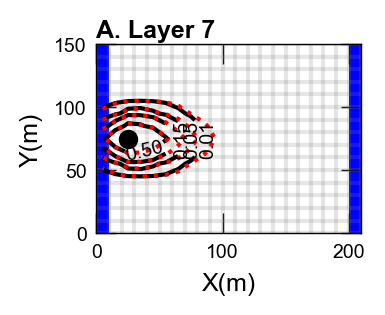

In [8]:
scenario(0)

In [9]:
chdspd = []
for k in np.arange(nlay):
    for i in np.arange(nrow):
        chdspd.append([(k, i, 0), strt[k, i, 0], 0.0])
        chdspd.append([(k, i, ncol - 1), strt[k, i, ncol - 1], 0.0])
chdspd = {0: chdspd}  ; type(chdspd)

dict

In [10]:
chdspd; 

In [11]:
# to get info outsite the function

In [12]:
# ... to file .. gx-gwt-mt3dms-p07_V01b___load__ ..